# Error Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import re
import spacy
from IPython.display import display
import dateutil.parser as dateutil_parser
from string import punctuation
from tqdm import tqdm
from config import Config
config = Config()
import utils
import eval.evaluate

%matplotlib inline

# Fix random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

nlp = spacy.load('en_core_web_sm')


In [2]:
# Ignores some problems on my system
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

## Dataset and predictions loading

In [3]:
TEST_DATASET_PATH = os.path.join(config.ROOT_PATH, 'data', 'dev_set.json')
VAL_DATASET_PATH = os.path.join(config.ROOT_PATH, 'data', 'validation_set.json')

PATH_TO_PREDICTIONS_TEST = os.path.join(config.ROOT_PATH, 'src', 'eval', 'normal_predictions_test_tpu.txt')
PATH_TO_PREDICTIONS_VAL = os.path.join(config.ROOT_PATH, 'src', 'eval', 'normal_predictions_val_tpu.txt')
PATH_TO_PREDICTIONS_BERT = os.path.join(config.ROOT_PATH, 'src', 'eval', 'bert_predictions_test_tpu.txt')

In [4]:
test_data = utils.read_question_set(TEST_DATASET_PATH)
validation_data = utils.read_question_set(VAL_DATASET_PATH)

prediction_test = utils.read_question_set(PATH_TO_PREDICTIONS_TEST)
prediction_val = utils.read_question_set(PATH_TO_PREDICTIONS_VAL)
prediction_test_bert = utils.read_question_set(PATH_TO_PREDICTIONS_BERT)

## Question categorization

The dataset contains many different types of questions and answers: some are related to dates, some other to people, other to places and so on. We want to understand how well our model performs on these different types of questions.

First of all, we must partition the questions into their types. We do this by understanding whether the related answer is numerical (cardinal) or non-numerical. Non-numerical answers are further categorized using NER tags and the associated tag is linked to the question. 


In [5]:
def is_numeric(answer:str):
    # A pattern that recognizes only-numerical answers
    return re.match('[0-9–]+', answer)

def is_date(answer:str):
    # We use a function from the dateutil module to understand 
    # if a given answer contains a date.
    try:
        dateutil_parser.parse(answer, fuzzy=False)
        return True
    except:
        return False
        
def get_question_type(question, answer):
    # We parse the answer using spacy's library
    answer = answer.strip(punctuation)
    doc = nlp(answer)

    for token in doc: 
        # print(f"{token.text:{8}} {token.dep_+' =>':{10}}   {token.head.text:{9}} {token.ent_type_}")
        if token.ent_type_:
            # If we find an entity type in the answer, we return it
            return (token.ent_type_).lower()
    # Otherwise we check if the answer is a date...
    if is_date(answer):
        return 'date'
    # ... a number...
    if is_numeric(answer):
        return 'cardinal'
    # ... if the question contains "Who"...
    if question[:3].lower() == "who":
        return "person"
    # ... and if the answer is none of these categories and it's quite long, we consider it 
    # a "clause"...
    if len(doc) >4:
        return "clause"
    # ... or "other".
    return "other"

We apply this analysis on the *test dataset* using the predictions made by our *normal* model.

In [6]:
def split_questions_type(data, prediction):
    questions_type = []
    # Iterate over all questions and answers of the test set
    for article in tqdm(data['data']):
        for paragraph in article['paragraphs']:
            for question_and_answer in paragraph["qas"]:

                qid = question_and_answer['id']
                # Obtain the ground truth answers
                gold_answers = [a['text'] for a in question_and_answer['answers']]
                # Obtain our prediction
                a_pred = prediction[qid]
                # Compute the exact and F1 score between this and the best-scoring GT answer
                exact_score = max(eval.evaluate.compute_exact(a, a_pred) for a in gold_answers)
                f1_score = max(eval.evaluate.compute_f1(a, a_pred) for a in gold_answers)
                # We get the answer, the question, the question type and the context
                answer = random.sample(gold_answers, 1)[0]
                question = question_and_answer["question"]
                question_type = get_question_type(question, answer)
                context = paragraph["context"]
                # ... and we append all of these details into the list.
                questions_type.append([question_type, question, answer, a_pred, context, f1_score, exact_score])
                # errors.append([question_type, question, context, answer])
    return questions_type

In [7]:
# We are then able to put all of these data into a dataframe
df = pd.DataFrame(split_questions_type(test_data, prediction_test), columns=["type", "question", "answer", "prediction", "context", "f1-score", "exact-score"])
df.head()

100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


,type,question,answer,prediction,context,f1-score,exact-score
0,gpe,Which NFL team represented the AFC at Super Bo...,Denver Broncos,Denver Broncos,Super Bowl 50 was an American football game to...,1.0,1
1,other,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,Carolina Panthers,Super Bowl 50 was an American football game to...,1.0,1
2,gpe,Where did Super Bowl 50 take place?,"Santa Clara, California",Levi's Stadium,Super Bowl 50 was an American football game to...,1.0,1
3,gpe,Which NFL team won Super Bowl 50?,Denver Broncos,Denver Broncos,Super Bowl 50 was an American football game to...,1.0,1
4,other,What color was used to emphasize the 50th anni...,gold,"gold-themed initiatives, as well as temporaril...",Super Bowl 50 was an American football game to...,0.0,0


Here, we use spacy to explain each of the tags from our dataset:

In [8]:
for type in df["type"].unique():
    print("Tag: '{}' --> {}".format(type, spacy.explain(type.upper())))

Tag: 'gpe' --> Countries, cities, states
Tag: 'other' --> None
Tag: 'date' --> Absolute or relative dates or periods
Tag: 'org' --> Companies, agencies, institutions, etc.
Tag: 'cardinal' --> Numerals that do not fall under another type
Tag: 'person' --> People, including fictional
Tag: 'ordinal' --> "first", "second", etc.
Tag: 'fac' --> Buildings, airports, highways, bridges, etc.
Tag: 'norp' --> Nationalities or religious or political groups
Tag: 'time' --> Times smaller than a day
Tag: 'product' --> Objects, vehicles, foods, etc. (not services)
Tag: 'clause' --> None
Tag: 'event' --> Named hurricanes, battles, wars, sports events, etc.
Tag: 'money' --> Monetary values, including unit
Tag: 'percent' --> Percentage, including "%"
Tag: 'work_of_art' --> Titles of books, songs, etc.
Tag: 'loc' --> Non-GPE locations, mountain ranges, bodies of water
Tag: 'quantity' --> Measurements, as of weight or distance
Tag: 'language' --> Any named language
Tag: 'law' --> Named documents made into 

Let's see the score divided on each category.

In [9]:
scores_by_group = []

for key in df["type"].unique():
    f1_score = df[df["type"] == key]["f1-score"].sum()
    exact_score = df[df["type"] == key]["exact-score"].sum()
    total = len(df[df["type"] == key]["f1-score"])
    scores_by_group.append([key, f1_score/total, exact_score/total, total])

scores_by_group = pd.DataFrame(scores_by_group, columns=['CATEGORY', 'F1 SCORE', 'EXACT SCORE', 'NUMBER OF ELEMENTS'])
scores_by_group.sort_values(by='NUMBER OF ELEMENTS', ascending=False)

,CATEGORY,F1 SCORE,EXACT SCORE,NUMBER OF ELEMENTS
1,other,0.738068,0.605837,3529
5,person,0.826570,0.769001,1342
3,org,0.802290,0.678922,1224
4,cardinal,0.712892,0.516796,1161
2,date,0.728215,0.535455,1100
11,clause,0.746300,0.565265,904
0,gpe,0.718039,0.557143,560
8,norp,0.757948,0.537906,277
16,loc,0.735038,0.620000,100
17,quantity,0.812478,0.563380,71


We check how many questions have a *completely wrong* answer, where we consider *completely wrong* as having an F1-Score less than 0.5 with the groundtruth.

In [10]:
F1_THRESHOLD=0.5

high_errors_df = df[df["f1-score"] < F1_THRESHOLD]
error_df = pd.DataFrame(high_errors_df.groupby("type", as_index=True).size().reset_index()).rename(columns={0: 'WRONG ANSWERS'})
errors_by_group = scores_by_group.merge(error_df, how='left', left_on='CATEGORY', right_on='type')[
        ['CATEGORY', 'F1 SCORE','EXACT SCORE', 'NUMBER OF ELEMENTS', 'WRONG ANSWERS']
    ]
errors_by_group['WRONG RATIO'] = errors_by_group['WRONG ANSWERS'] / errors_by_group['NUMBER OF ELEMENTS']
errors_by_group = errors_by_group.set_index('CATEGORY')
errors_by_group.sort_values('WRONG RATIO', ascending=False)

,F1 SCORE,EXACT SCORE,NUMBER OF ELEMENTS,WRONG ANSWERS,WRONG RATIO
CATEGORY,,,,,
language,0.595238,0.500000,6,3,0.500000
ordinal,0.670645,0.468750,64,18,0.281250
loc,0.735038,0.620000,100,27,0.270000
gpe,0.718039,0.557143,560,145,0.258929
clause,0.746300,0.565265,904,214,0.236726
other,0.738068,0.605837,3529,832,0.235761
event,0.801423,0.681818,22,5,0.227273
cardinal,0.712892,0.516796,1161,263,0.226529
product,0.781008,0.709677,31,7,0.225806


From this analysis, we can see that our model gets really wrong a lot of questions about **numbers**, be it *cardinal numbers*, *money* or *quantities*. We can explain this by the fact that the tokenizer probably splits numbers that are not *common*, ignoring the fact that a number has value on its own, not just as a word.

Long answers which don't have a clear type are also a problem.

We show the kinds of mistakes our model makes using the following pie charts:

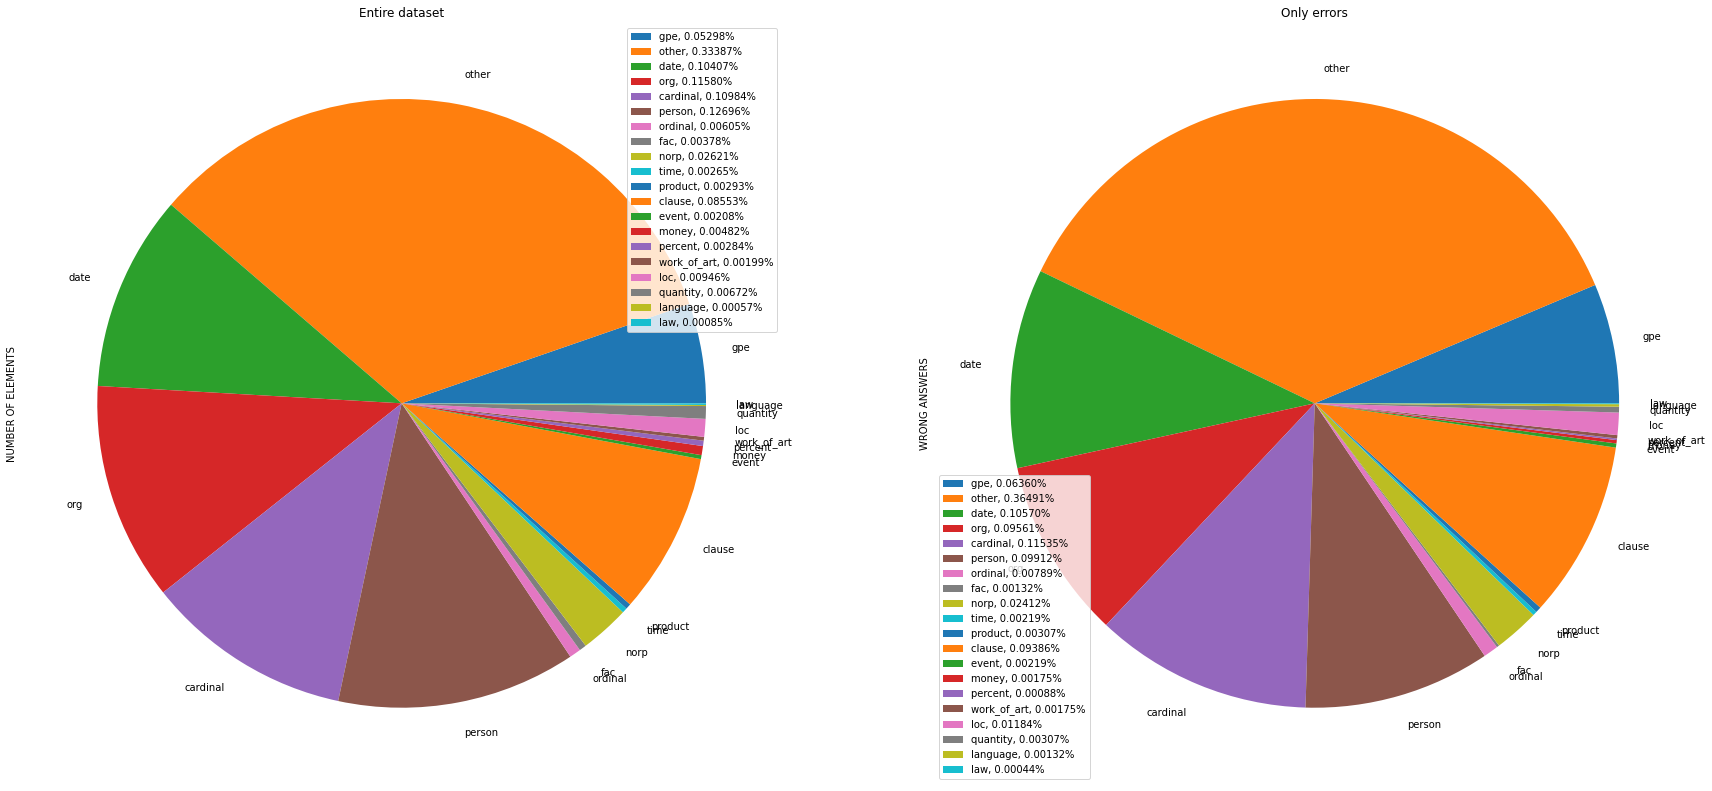

In [11]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(30,30))
ax1.set_title("Entire dataset")
errors_by_group.plot.pie(y='NUMBER OF ELEMENTS', ax=ax1);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group.index), 
    errors_by_group['NUMBER OF ELEMENTS']/errors_by_group['NUMBER OF ELEMENTS'].sum())]
ax1.legend(labels)

ax2.set_title("Only errors")
errors_by_group.plot.pie(y='WRONG ANSWERS', ax=ax2);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group.index), 
    errors_by_group['WRONG ANSWERS']/errors_by_group['WRONG ANSWERS'].sum())]

ax2.legend(labels)

The quantities of errors overall match the data distribution.

Now, we analyze some of the errors for each question category:

In [12]:
errors_by_group_sorted = errors_by_group.sort_values(by='WRONG ANSWERS', ascending=False)

for key in list(errors_by_group_sorted.index):
    if len(high_errors_df[high_errors_df["type"]==key])>1:
        samples = high_errors_df[high_errors_df["type"]==key].drop(["f1-score", "exact-score"], axis=1).sample(2)
        print(key)
        display(samples)
    print()

other


,type,question,answer,prediction,context
7551,other,What happens to the GDP growth of a country if...,declines,declines over the medium term,According to International Monetary Fund econo...
10521,other,What is the observable effect of W and Z boson...,beta decay,weak force,The weak force is due to the exchange of the h...



cardinal


,type,question,answer,prediction,context
602,cardinal,"How many other contestants did the company, th...",nine,nine other contenders from across the United S...,"QuickBooks sponsored a ""Small Business Big Gam..."
5020,cardinal,"How many people, at most, have died of plague ...",two-thirds of its population,two-thirds,The Black Death ravaged much of the Islamic wo...



date


,type,question,answer,prediction,context
9946,date,When was Otto von Bismarck born?,1862,(1862–90,"Not a maritime power, and not a nation-state, ..."
5881,date,When did Sunday Night Football premiere on NBC?,2006,"1970, ABC debuted Monday Night Football as par...","In 1970, ABC debuted Monday Night Football as ..."



person


,type,question,answer,prediction,context
9600,person,Who did the SNP obtain 16 seats from?,Labour,"Labour, with many of their key figures not ret...",The election produced a majority SNP governmen...
8988,person,What is the name of one algorithm useful for c...,Miller–Rabin primality test,trial division. It consists of testing whether...,The property of being prime (or not) is called...



org


,type,question,answer,prediction,context
1891,org,What is another general name for a religious t...,spiritual,gurus,"Religious and spiritual teachers, such as guru..."
8670,org,Who published the State of the Planet 2008-200...,Science Magazine,"Michael Oppenheimer, a long-time participant i...","Michael Oppenheimer, a long-time participant i..."



clause


,type,question,answer,prediction,context
6175,clause,What aspect of the economy did Genghis Khan ex...,understanding the motivations of his rivals,military strategies,Accounts of Genghis Khan's life are marked by ...
5122,clause,What prompted Shen Kuo to believe the land was...,his observation of fossil animal shells,deposition of silt,"Some modern scholars, such as Fielding H. Garr..."



gpe


,type,question,answer,prediction,context
2944,gpe,Where was Victoria first set to be located in ...,New South Wales,Sullivan Bay,"Prior to European settlement, the area now con..."
9937,gpe,Where did France lose a war in the 1950's?,Vietnam,Vietnam in the 1950s. Whereas they won the war...,"In World War II, Charles de Gaulle and the Fre..."



norp


,type,question,answer,prediction,context
9871,norp,Who besides the british colonized Africa?,French,French and British power,"To better illustrate this idea, Bassett focuse..."
10326,norp,"During withdrawal from Fort William Henry, wha...",attacked the British column,angered at the lost opportunity for loot,French irregular forces (Canadian scouts and I...



loc


,type,question,answer,prediction,context
9995,loc,The Ottoman empire controlled territory on thr...,Europe,"the Caucasus, North Africa, and the Horn of Af...",The Ottoman Empire was an imperial state that ...
4941,loc,Did the plague spread in Scandinavia or German...,Scandinavia,Scandinavia and then Germany,Gasquet (1908) claimed that the Latin name atr...



ordinal


,type,question,answer,prediction,context
3560,ordinal,What gave Priestley the claim to being the fir...,his work was published first,discredit the then-popular phlogiston theory o...,Oxygen was discovered independently by Carl Wi...
2771,ordinal,What ranking in terms of busiest airports from...,third,second-busiest airport in the United States by...,Southern California is home to Los Angeles Int...



quantity


,type,question,answer,prediction,context
7300,quantity,What is the land area of Jacksonville?,874.3 square miles,"874.3 square miles (2,264 km2), making Jackson...","According to the United States Census Bureau, ..."
3951,quantity,"How far did the second block, AS-202, travel d...","25,700 km","13,900 nautical miles",Two Block I CSMs were launched from LC-34 on s...



product


,type,question,answer,prediction,context
7900,product,What was the name of the first Doctor Who stor...,Doctor Who and the Pescatons,The Chase,The earliest Doctor Who-related audio release ...
10382,product,Who experimented by rolling stones and canonba...,Galileo,"Galileo Galilei, who was influenced by the lat...",The shortcomings of Aristotelian physics would...



event


,type,question,answer,prediction,context
9907,event,When were Joseph Schumpeter and Norman Angell ...,"before World War I,",(1872–1967). While these non-Marxist writers w...,"The correlation between capitalism, aristocrac..."
1038,event,What brought Warsaw's stock exchange to a stop?,World War II,end of the post-war communist control of the c...,Warsaw's first stock exchange was established ...



time


,type,question,answer,prediction,context
1594,time,Before dinner what were Tesla's working hours?,9:00 a.m. until 6:00 p.m,every day,Tesla worked every day from 9:00 a.m. until 6:...
2356,time,At what point in the day was the couple married?,evening,"13 June 1525, the couple was engaged with Joha...","On 13 June 1525, the couple was engaged with J..."



money


,type,question,answer,prediction,context
1307,money,How much did Tesla say Edison offered him to r...,fifty thousand dollars,US$10 a week raise,Tesla was offered the task of completely redes...
4160,money,What is defined as the majority vote?,"74 per cent, or 260 of the 352 votes","qualified majority vote, if not consensus",The second main legislative body is the Counci...



work_of_art


,type,question,answer,prediction,context
7941,work_of_art,What Doctor Who episode won a Hugo Award in 2010?,The Waters of Mars,"""The Empty Child""/""The Doctor Dances"" (2006), ...",It has won the Short Form of the Hugo Award fo...
10012,work_of_art,"Why was the student group called ""the Methodis...",being methodical and exceptionally detailed in...,started individual societies or classes for me...,The movement which would become The United Met...



fac


,type,question,answer,prediction,context
5195,fac,Why have Newcastle and Gateshead linked togeth...,to spearhead the regeneration of the North-East,"""NewcastleGateshead",Large-scale regeneration has replaced former s...
5439,fac,What was the building that formerly occupied t...,Brompton Park House,"Brompton Park House, which was extended, most ...",The Victorian parts of the building have a com...



language


,type,question,answer,prediction,context
7067,language,"In Nepalese private schools, what is the prima...",English,"English, but as a compulsory subject, Nepali",The other category of schools are those run an...
7053,language,"In private schools, what language are classes ...",English,English while it is the local language,"Legally, only non-profit trusts and societies ..."



percent


,type,question,answer,prediction,context
941,percent,How much of Warsaw's population was Jewish?,some 30% of the city,several hundred thousand,After the German Invasion of Poland on 1 Septe...
7346,percent,Who owns more wealth than the bottom 90 percen...,richest 1 percent,the top 400 richest Americans,According to PolitiFact the top 400 richest Am...


We can see that:
- Some errors are related to having a few words more or less with respect to the ground truth answer
    - For instance, questions related to years often repeat a large part of the context, while the ground truth answer is simply the year.
    - These are not exactly *wrong* answers, they're just not precise/unfocused.
- The model doesn't seem to fully understand which number or quantity is related to what entity in the sentence: there are multiple instances where the prediction cites a number in the paragraph that is related to something different than what the question is asking
    - Nonetheless a number or quantity is selected, so we can say there is an understanding of the type of question that is being asked.
- This is a general problem: when there are multiple Named Entities of the same type in the paragraph, the model might select one that is not the correct answer but has the same functionality:
    - Like citing a different Doctor Who episode that is present in the paragraph, but is not the "Hugo Award" winner in 2010
- Also, if the answer contains elements from other languages, they can be lost because the model does not understand deeply other languages.


## Dataset split difference

We have noticed a big difference in performances between validation and test sets, so we need to investigate this gap.

In [14]:
df_val = pd.DataFrame(split_questions_type(validation_data, prediction_val), columns=["type", "question", "answer", "prediction", "context", "f1-score", "exact-score"])

df_val.head()

100%|██████████| 111/111 [04:13<00:00,  2.28s/it]


,type,question,answer,prediction,context,f1-score,exact-score
0,other,k,ks,"ROC, Jing","Nanjing ( listen; Chinese: 南京, ""Southern Capit...",0.0,0
1,other,j,Ch,"ROC, Jing","Nanjing ( listen; Chinese: 南京, ""Southern Capit...",0.0,0
2,other,n,n,"ROC, Jing","Nanjing ( listen; Chinese: 南京, ""Southern Capit...",0.0,0
3,other,b,b,"ROC, Jing","Nanjing ( listen; Chinese: 南京, ""Southern Capit...",0.0,0
4,other,v,v,"ROC, Jing","Nanjing ( listen; Chinese: 南京, ""Southern Capit...",0.0,0


First of all, there are a bit of junk questions and answers. 

In [15]:
junky_questions = df_val[df_val["question"].str.len()<6]

print("junky question information")
print("number of question with less than 6 character:", junky_questions.shape[1])


junky question information
number of question with less than 6 character: 7


Still there aren't enough junky questions to justify the gap.

Let's see the score divided for each category.

In [17]:
scores_by_group_val = []

for key in df_val["type"].unique():
    f1_score = df_val[df_val["type"] == key]["f1-score"].sum()
    exact_score = df_val[df_val["type"] == key]["exact-score"].sum()
    total = len(df_val[df_val["type"] == key]["f1-score"])
    scores_by_group_val.append([key, f1_score/total, exact_score/total, total])

scores_by_group_val = pd.DataFrame(scores_by_group_val, columns=['CATEGORY', 'F1 SCORE', 'EXACT SCORE', 'NUMBER OF ELEMENTS'])
scores_by_group_val.sort_values(by='NUMBER OF ELEMENTS', ascending=False)

,CATEGORY,F1 SCORE,EXACT SCORE,NUMBER OF ELEMENTS
0,other,0.681425,0.505766,6677
6,person,0.801788,0.692622,2941
4,date,0.678085,0.408512,2749
5,cardinal,0.676832,0.437956,2740
3,org,0.731489,0.551518,2009
7,clause,0.601553,0.303393,2004
1,gpe,0.625031,0.429635,1478
9,norp,0.670898,0.453829,888
2,loc,0.691614,0.507812,256
11,ordinal,0.592016,0.284884,172


And the score about the questions that we consider *completely wrong*.

In [18]:
F1_THRESHOLD=0.5

high_errors_df_val = df_val[df_val["f1-score"] < F1_THRESHOLD]
error_df_val = pd.DataFrame(high_errors_df_val.groupby("type", as_index=True).size().reset_index()).rename(columns={0: 'WRONG ANSWERS'})
errors_by_group_val = scores_by_group_val.merge(error_df_val, how='left', left_on='CATEGORY', right_on='type')[
        ['CATEGORY', 'F1 SCORE','EXACT SCORE', 'NUMBER OF ELEMENTS', 'WRONG ANSWERS']
    ]
errors_by_group_val['WRONG RATIO'] = errors_by_group_val['WRONG ANSWERS'] / errors_by_group_val['NUMBER OF ELEMENTS']
errors_by_group_val = errors_by_group_val.set_index('CATEGORY')
errors_by_group_val.sort_values('WRONG RATIO', ascending=False)

,F1 SCORE,EXACT SCORE,NUMBER OF ELEMENTS,WRONG ANSWERS,WRONG RATIO
CATEGORY,,,,,
clause,0.601553,0.303393,2004,752,0.375250
gpe,0.625031,0.429635,1478,549,0.371448
percent,0.622892,0.352113,71,24,0.338028
ordinal,0.592016,0.284884,172,54,0.313953
norp,0.670898,0.453829,888,266,0.299550
law,0.704789,0.513514,37,11,0.297297
work_of_art,0.670997,0.323529,34,10,0.294118
language,0.767571,0.476190,21,6,0.285714
loc,0.691614,0.507812,256,72,0.281250


We still have not found a reason for such gap, so we compare the data distribuition of test set and the validation set.

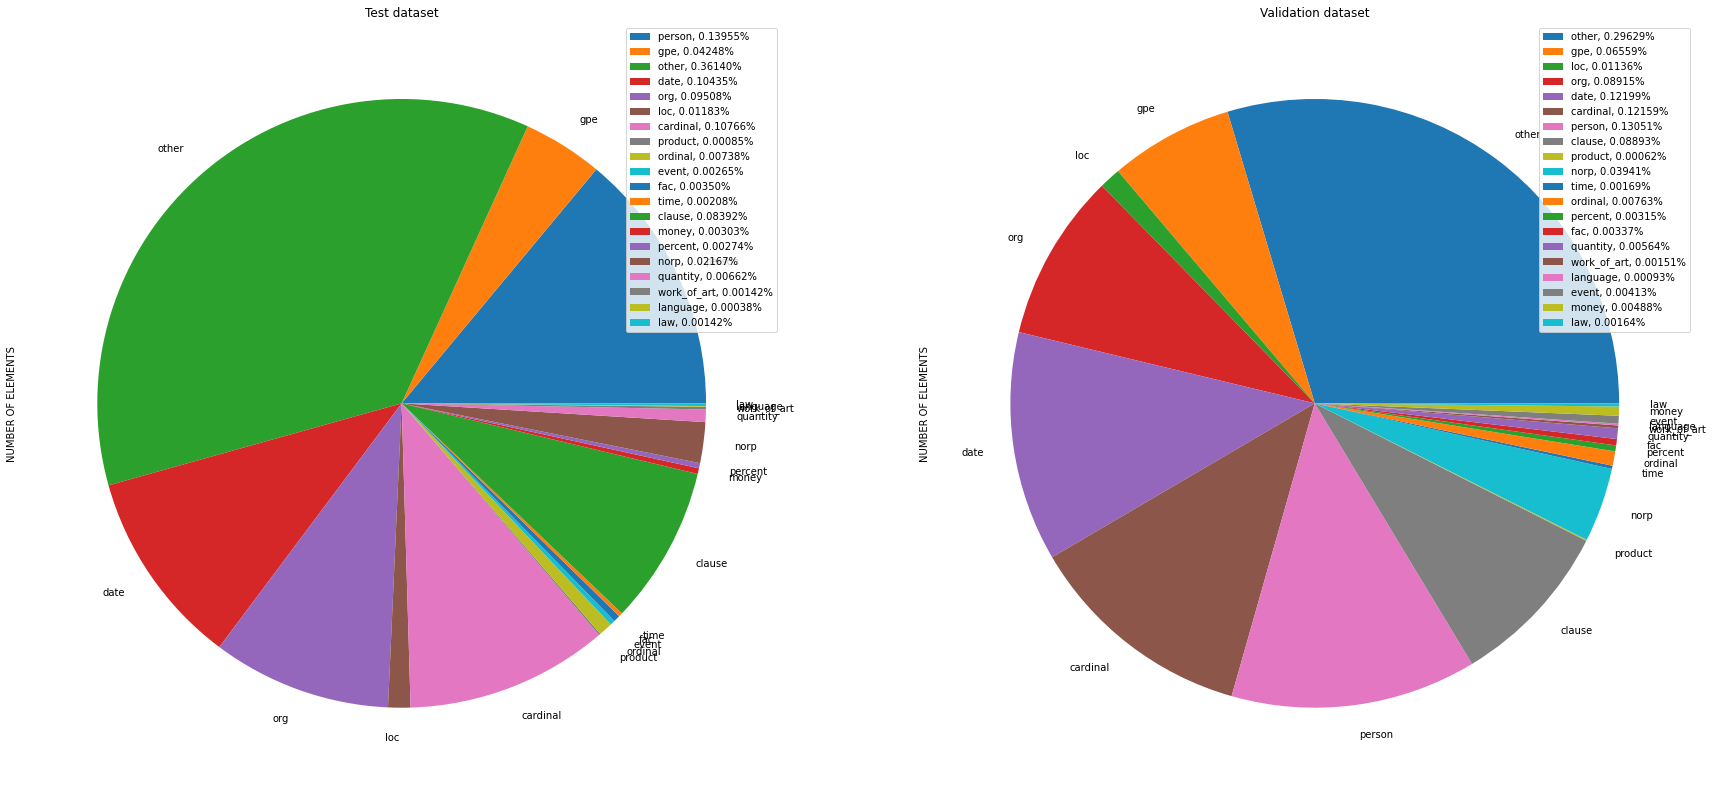

In [19]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(30,30))
ax1.set_title("Test dataset")
errors_by_group.plot.pie(y='NUMBER OF ELEMENTS', ax=ax1);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group.index), 
    errors_by_group['NUMBER OF ELEMENTS']/errors_by_group['NUMBER OF ELEMENTS'].sum())]
ax1.legend(labels)
ax2.set_title("Validation dataset")
errors_by_group_val.plot.pie(y='NUMBER OF ELEMENTS', ax=ax2);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group_val.index), 
    errors_by_group_val['NUMBER OF ELEMENTS']/errors_by_group_val['NUMBER OF ELEMENTS'].sum())]
ax2.legend(labels)

We also compare the error distribution:

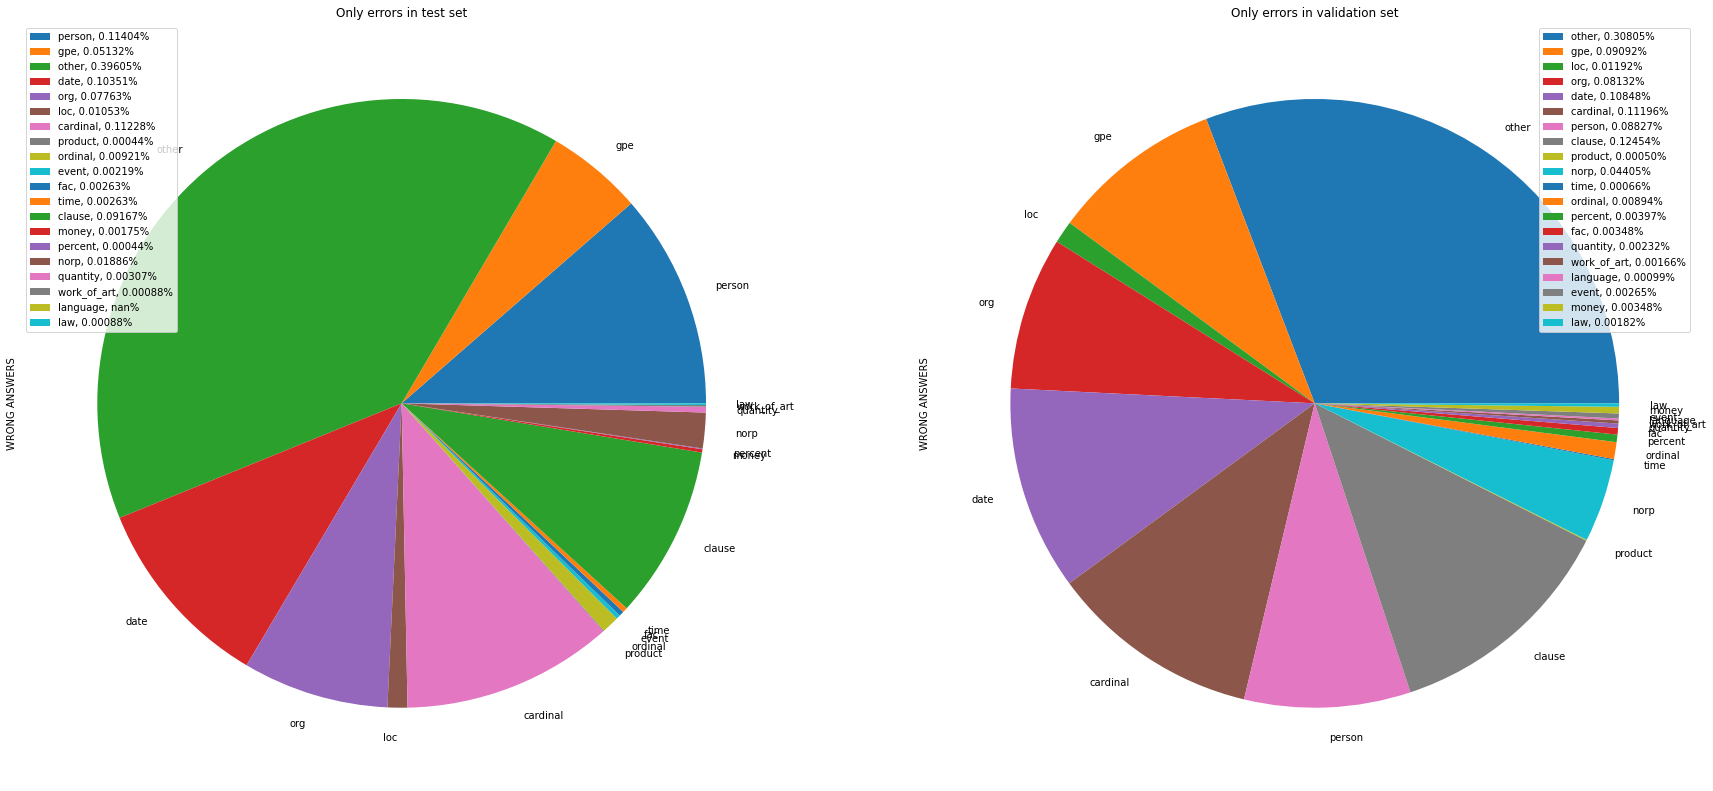

In [20]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(30,30))
ax1.set_title("Only errors in test set")
errors_by_group.plot.pie(y='WRONG ANSWERS', ax=ax1);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group.index), 
    errors_by_group['WRONG ANSWERS']/errors_by_group['WRONG ANSWERS'].sum())]
ax1.legend(labels)
ax2.set_title("Only errors in validation set")
errors_by_group_val.plot.pie(y='WRONG ANSWERS', ax=ax2);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group_val.index), 
    errors_by_group_val['WRONG ANSWERS']/errors_by_group_val['WRONG ANSWERS'].sum())]
ax2.legend(labels)

The data distribution and the error distribution are overall the same for both the data splits.

The gap is actually caused by the fact that the test set contains many answers for a question and the evaluation script selects the best scoring one.

We will not prove this claim here because it requires the code in the `evaluation_test` notebook, but the experiment was done like this:

The evaluation script obtains raw scores with this function:
```python
def get_raw_scores(dataset, preds):
  exact_scores = {}
  f1_scores = {}
  for article in dataset:
    for p in article['paragraphs']:
      for qa in p['qas']:
        qid = qa['id']
        gold_answers = [a['text'] for a in qa['answers']
                        if normalize_answer(a['text'])]
        if not gold_answers:
          # For unanswerable questions, only correct answer is empty string
          gold_answers = ['']
        if qid not in preds:
          print('Missing prediction for %s' % qid)
          continue
        a_pred = preds[qid]
        # Take max over all gold answers
        exact_scores[qid] = max(compute_exact(a, a_pred) for a in gold_answers)
        f1_scores[qid] = max(compute_f1(a, a_pred) for a in gold_answers)
  return exact_scores, f1_scores
```

We modified the function like this:

```python
def get_raw_scores(dataset, preds):
  exact_scores = {}
  f1_scores = {}
  for article in dataset:
    for p in article['paragraphs']:
      for qa in p['qas']:
        qid = qa['id']
        gold_answers = [a['text'] for a in qa['answers']
                        if normalize_answer(a['text'])]
        if not gold_answers:
          # For unanswerable questions, only correct answer is empty string
          gold_answers = ['']
        if qid not in preds:
          print('Missing prediction for %s' % qid)
          continue
        # THE CHANGES START HERE: WE TAKE A RANDOM GROUND TRUTH ANSWER RATHER THAN 
        # USING ALL OF THEM AND TAKING THE MAX
        a_gold = random.choice(gold_answer)
        a_pred = preds[qid]
        # Take max over all gold answers
        exact_scores[qid] = compute_exact(a_gold, a_pred)
        f1_scores[qid] = compute_f1(a_gold, a_pred)
  return exact_scores, f1_scores
```

The subsequent evaluation on the test set using the normal model gave us results that are very close to those on the validation set:

| Type                    | Exact score | F1 Score |
|:------------------------|:-----------:|:--------:|
|Normal Test set          |61.17%       |  75.53%  |
|Random Selection Test Set|48.23%       | 67.90%   |
|Validation Set           |48.71%       | 69.03%   |
